# Is there still magic in the FA cup?

*An attempt to study whether the FA cup still retains its magic, i.e. whether or not weaker/lower division teams can make it to the latter stages of the cup. This project was initiated to investigate the common complaint of football "pundits" - that the FA cup is no longer magical. While it's hard to know what is meant by such a complaint, one quantitative metric is the number of lower division teams upsetting high division teams. We also investigate goals scored by lower division teams, and the proportion of lower division teams making it through to the later rounds of the competition.*

In [140]:
#As usual import some modules as import the dataset
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#import the data
facup = pd.read_csv("data/facup.csv")
allgames = pd.read_csv("data/engsoccerdata2.csv")

#A utility function for calculating moving averages
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

#Look at some of the data
facup.head(5)

date  Season                 home              visitor   FT  hgoal  \
0  1871-11-11    1871               Barnes        Civil Service  2-0      2   
1  1871-11-11    1871              Hitchin  Crystal Palace 1861  0-0      0   
2  1871-11-11    1871    Maidenhead United               Marlow  2-0      2   
3  1871-11-11    1871           Upton Park       Clapham Rovers  0-3      0   
4  1871-12-16    1871  Crystal Palace 1861    Maidenhead United  3-0      3   

   vgoal round      tie  aet  pen pens  hp  vp                   Venue  \
0      0     1  initial  NaN  NaN  NaN NaN NaN                     NaN   
1      0     1  initial  NaN  NaN  NaN NaN NaN      Top Field, Hitchin   
2      0     1  initial  NaN  NaN  NaN NaN NaN   York Road, Maidenhead   
3      3     1  initial  NaN  NaN  NaN NaN NaN   West Ham Park, London   
4      0     2  initial  NaN  NaN  NaN NaN NaN  Crystal Palace, London   

  attendance nonmatch                           notes neutral  
0      1,200      NaN                             NaN     NaN  
1        750      NaN  No replay, both teams progress     NaN  
2      1,287      NaN                             NaN     NaN  
3      1,500      NaN                             NaN     NaN  
4        NaN      NaN                             NaN     NaN

# Historical trend of replays (proxy of competitiveness?)
**First group by types of games**

In [44]:
#First copy the data frame
facup_mod = facup.copy()

#Replace all instances of replay with just a single demarcation
facup_mod.replace('replay[1234]','replay',inplace = True,regex = True)

#Add a couple new columns to show whether a game is a tie or a replay
season_tie = pd.crosstab(index = facup_mod["Season"], columns = facup_mod["tie"])

#Finally print some data to show what we've done
print season_tie.tail(4)
facup

tie     initial  leg1  leg2  none  replay
Season                                   
2011        123     0     0     0      28
2012        123     0     0     0      33
2013        123     0     0     0      18
2014        123     0     0     0      30


**Now plot the results**

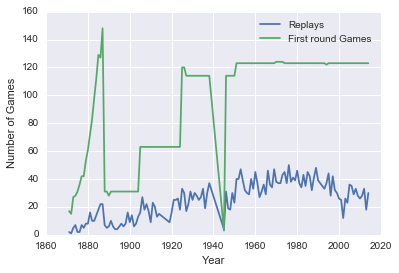

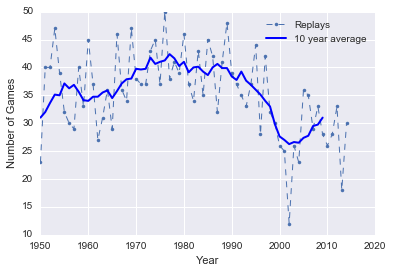

In [96]:
#Initialize a figure, and use seaborn to plot
fig = sns.plt.figure()
y_av = movingaverage(season_tie["replay"], 8)
sns.plt.figure(1)
sns.plt.plot(season_tie["replay"])
sns.plt.plot(season_tie["initial"])
sns.plt.xlabel("Year")
sns.plt.ylabel("Number of Games")
sns.plt.legend(["Replays","First round Games"])
sns.plt.figure(2)
sns.plt.plot(season_tie["replay"].loc[1950:],'.--', linewidth = 1)
sns.plt.plot(season_tie.index[-65:-5],y_av[-65:-5], '-', color = 'b',linewidth = 2)
sns.plt.xlabel("Year")
sns.plt.ylabel("Number of Games")
sns.plt.legend(["Replays", "10 year average"])

sns.plt.show()
fig.savefig("figures/replays.png")

## Getting divisional information for clubs

In [58]:
#First note that there is a large discrepancy between the number of clubs in the top 4 divisions
#, and the number of clubs who play in the FA cup - this makes sense because ALL english clubs play
# in the FA cup, while fewer (only 142) have made it to league level

#Number of unique FA cup teams
print len(facup['home'].unique())
print len(facup['visitor'].unique())
#Number of unique teams in all english league cup games
print len(allgames['home'].unique())
print len(allgames['visitor'].unique())

618
695
142
142


In [59]:
#Have a look at the allgames table
allgames.head(4)

Date  Season             home           visitor   FT  hgoal  vgoal  \
0  1888-12-15    1888  Accrington F.C.       Aston Villa  1-1      1      1   
1  1889-01-19    1888  Accrington F.C.  Blackburn Rovers  0-2      0      2   
2  1889-03-23    1888  Accrington F.C.  Bolton Wanderers  2-3      2      3   
3  1888-12-01    1888  Accrington F.C.           Burnley  5-1      5      1   

  division  tier  totgoal  goaldif result  
0        1     1        2        0      D  
1        1     1        2       -2      A  
2        1     1        5       -1      A  
3        1     1        6        4      H

In [68]:
#Now narrow down this table to only the unique instances of a team, its season and tier
# print allgames['tier'].unique()
# Gives answer [1,2,3,4]

#Because all clubs are represented in the home team column, we can narrow
#down the table to only include three columns
onlyranks = allgames[['Season','home','tier']]


#Now drop duplicate rows, i.e. every row of the table is now 
# a unique Season, Team and its league position for that season
onlyranks = onlyranks.drop_duplicates()
onlyranks = onlyranks.sort_values(by = ['home','Season'])


#Now do a merge on the season and home team
result = pd.merge(facup, onlyranks, how='left', on =['home','Season'])
result.rename(columns={'tier':'home_tier'}, inplace=True)


#Now repeat the merge for the visitor team, first doing some renaming
onlyranks.rename(columns={'home':'visitor'}, inplace=True)
facup_tiers = pd.merge(result, onlyranks, how = 'left', on = ['visitor','Season'])
facup_tiers.rename(columns={'tier':'visitor_tier'}, inplace=True)

#Now return the team name column to "home"
onlyranks.rename(columns={'visitor':'home'}, inplace=True)

### Team's divisional position vs. time

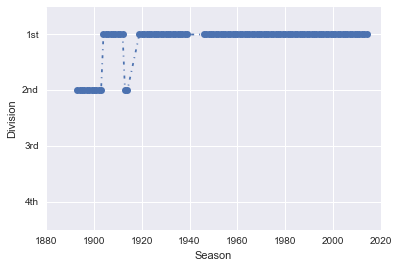

In [87]:
#Next, visualize how a team has done over the years
team = 'Arsenal'


fig = sns.plt.plot(onlyranks[onlyranks['home'] == team]['Season'], onlyranks[onlyranks['home'] == team]['tier'],'o-.')
sns.plt.ylim((4.5,0.5))
sns.plt.yticks([1,2,3,4], ["1st","2nd","3rd","4th"])
sns.axlabel("Season", "Division")
sns.plt.show()

## Categorize games as upset or not

In [136]:
# Make a copy of the table above
facup2 = facup_tiers.copy()
#Remove illegitimate values
facup2.dropna(subset =['FT'],inplace = True)

#When a tier for a team isn't available, treat that team as Divison 5
facup2['home_tier'].fillna(5, inplace = True)
facup2['visitor_tier'].fillna(5, inplace = True)


#Define a function which calcualtes whether or not the lower division team won
def upset(htier,vtier,hgoal,vgoal):
    if (vtier == 1 and htier > vtier and hgoal > vgoal):
        #Visitor team in Div. 1, Home team in lower division, Home team wins
        return 'PU' #Premier league team was upset
    elif (htier == 1 and htier < vtier and hgoal < vgoal):
        return 'PU' 
    elif (htier < vtier and hgoal < vgoal):
        return 'U' #Lower Div team beat team in division above them
    elif (htier > vtier and hgoal > vgoal):
        return 'U'
    elif (htier != vtier and hgoal == vgoal and (htier == 1 or vtier ==1) ):
        return 'PD'#Lower Div team drew with Premier league team
    elif (htier != vtier and hgoal == vgoal):
        return 'D'
    else:
        return 'E'
    

#Create new columns detailing whether a game was indeed an upset
facup2['upset'] = facup2.apply(lambda row: upset(row['home_tier'], row['visitor_tier'],row['hgoal'],row['vgoal']), axis=1)

#have a look at the new table
facup2.head(5)

date  Season                 home              visitor   FT  hgoal  \
0  1871-11-11    1871               Barnes        Civil Service  2-0      2   
1  1871-11-11    1871              Hitchin  Crystal Palace 1861  0-0      0   
2  1871-11-11    1871    Maidenhead United               Marlow  2-0      2   
3  1871-11-11    1871           Upton Park       Clapham Rovers  0-3      0   
4  1871-12-16    1871  Crystal Palace 1861    Maidenhead United  3-0      3   

   vgoal round      tie  aet  ...    hp  vp                   Venue  \
0      0     1  initial  NaN  ...   NaN NaN                     NaN   
1      0     1  initial  NaN  ...   NaN NaN      Top Field, Hitchin   
2      0     1  initial  NaN  ...   NaN NaN   York Road, Maidenhead   
3      3     1  initial  NaN  ...   NaN NaN   West Ham Park, London   
4      0     2  initial  NaN  ...   NaN NaN  Crystal Palace, London   

   attendance nonmatch                           notes neutral home_tier  \
0       1,200      NaN                             NaN     NaN         5   
1         750      NaN  No replay, both teams progress     NaN         5   
2       1,287      NaN                             NaN     NaN         5   
3       1,500      NaN                             NaN     NaN         5   
4         NaN      NaN                             NaN     NaN         5   

  visitor_tier  upset  
0            5      E  
1            5      E  
2            5      E  
3            5      E  
4            5      E  

[5 rows x 22 columns]

In [132]:
#Clean up the table to include only 'relevant' columns, and now crosstabulate vs. season
facup2 = facup2[['date','Season','home','visitor','FT','hgoal','vgoal','round','tie','aet','home_tier','visitor_tier','upset']]
upsets = pd.crosstab(index = facup2["Season"], columns = facup2["upset"])

# Plot of Number of upsets vs. years

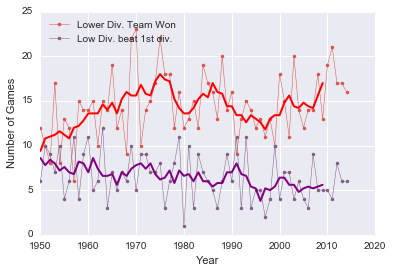

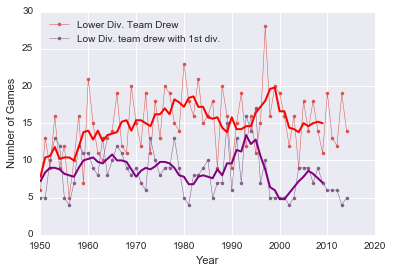

In [139]:

#Finally print some data to show what we've done
#print grouped.head(20)

#Define a couple moving averages
y_av = movingaverage(upsets["U"], 5)
y2_av = movingaverage(upsets["PU"], 5)

initYear = 1950
diff = 2015 - initYear

fig = sns.plt.figure()
sns.plt.figure(1)
sns.color_palette("hls", 8)
#Plot the data
sns.plt.plot(upsets["U"].loc[initYear:],'.-' ,color = sns.xkcd_rgb["pale red"],linewidth = 0.5)
sns.plt.plot(upsets["PU"].loc[initYear:],'.-',color = sns.xkcd_rgb["dusty purple"], linewidth = 0.5)
sns.plt.plot(upsets.index[-diff:-5],y_av[-diff:-5],'-',color = 'r',linewidth = 2)
sns.plt.plot(upsets.index[-diff:-5],y2_av[-diff:-5],'-',color ='purple',linewidth = 2)
#Fiddle with the axes
sns.plt.xlabel("Year")
sns.plt.ylabel("Number of Games")
sns.plt.legend(["Lower Div. Team Won","Low Div. beat 1st div."], loc = 2)
fig.savefig("figures/wins.png")
fig = sns.plt.figure()


sns.plt.figure(2)

#Define a couple moving averages
y_av = movingaverage(upsets["D"], 5)
y2_av = movingaverage(upsets["PD"], 5)

#Now plot
sns.plt.plot(upsets["D"].loc[initYear:],'.-' ,color = sns.xkcd_rgb["pale red"],linewidth = 0.5)
sns.plt.plot(upsets["PD"].loc[initYear:],'.-',color = sns.xkcd_rgb["dusty purple"], linewidth = 0.5)
sns.plt.plot(upsets.index[-diff:-5],y_av[-diff:-5],'-',color = 'r',linewidth = 2)
sns.plt.plot(upsets.index[-diff:-5],y2_av[-diff:-5],'-',color ='purple',linewidth = 2)
#Fiddle with the axes
sns.plt.xlabel("Year")
sns.plt.ylabel("Number of Games")
sns.plt.legend(["Lower Div. Team Drew","Low Div. team drew with 1st div."], loc = 2)
fig.savefig("figures/draws.png")

sns.plt.show()